# Tema 21: Curvas ROC

Las curvas de Característica Operativa del Receptor es muy utilizada para identificar puntos de corte maximizando la sensibilidad y especificidad de una prueba con resultado binario.

:::{important}
Para esta libreta es necesario tener instalada la librería `scikit-learn`, puedes hacerlo con el comando `uv add scikit-learn` dentro del directorio del curso.

Observa, sin embargo, que a la hora de importar la librería se hace como `sklearn`, esto se debe a restricciones en el nombre de las variables en python y a la comodidad de un nombre más corto. 
:::

## Librerías


In [ ]:
import scipy.stats as stats # pruebas y distribuciones
from scipy.special import expit # logit inversa
import numpy as np # librería de cálculos matemáticos y vectores
import pandas as pd # manejo de datos tabulados
from sklearn.metrics import roc_curve, auc # para la curva ROC

import matplotlib.pyplot as plt # para graficar.

print("Librerías importadas")

Librerías importadas


## Datos
Utilizaremos datos con una variable predictora numérica discreta en el intervalo 0-40 con distribución normal. 

En esta libreta también utilizaremos datos simulados, sin embargo, esta vez correremos la simulación al momento de ejecutar la libreta, es decir, que en cada caso los datos generados serán únicos para tí. Sin embargo, para hacerlo replicable, utilizaremos el concepto de `semilla` aleatoria.

:::{important}
Cuando utilizamos una semilla aleatoria el algoritmo generador de números pseudo-aleatorios operará en forma determinística.
Es decir, que a pesar de que los números sean *aleatorios*, aparecerán en el mismo orden cada vez.

Esto es crítico para la reproducibilidad de resultados en pruebas que dependen de números aleatorios, por ejemplo, [bootstrap](https://en.wikipedia.org/wiki/Bootstrapping_(statistics))
:::

### Semilla aleatoria

#### Demostración
Para ver cómo funciona la semilla ejecuta la siguiente celda.
Utilizaremos `numpy`, una librería para operaciones matemáticas con vectores y matrices; está en el corazón de librerías como `pandas` y `scipy` y por lo tanto es donde debemos "sembrar" la `semilla`.

##### Ejemplo sin semilla
Ejecuta la siguiente celda el número de veces que gustes, pero al menos más de dos veces.
Verás que en cada ejecución los números generados cambian.

In [10]:
# quitamos cualquier efecto de seed que quede en la memoria
# solo en caso de que hayamos corrido alguna semilla antes de esta celda
np.random.seed(None)
for _ in range(10): # 10 números del 0 al 9
    n = np.random.randint(0, 100) # número aleatorio del 0 al 100
    print(n)

5
64
55
28
98
54
49
14
58
81


##### Ejemplo con semilla
Ahora utilizamos la semilla `42`, repite el ejercicio previo, ejecuta la siguiente celda múltiples veces pero al menos más de dos.

In [17]:
np.random.seed(42) # el argumento puede ser cualquier int
for _ in range(10): # 10 números del 0 al 9
    n = np.random.randint(0, 100) # número aleatorio del 0 al 100
    print(n)


51
92
14
71
60
20
82
86
74
74


Como ves, a pesar de que los números son "aleatorios", al utilizar una semilla, podemos replicar la misma secuencia cada vez.

#### Elije tu semilla
En la siguiente celda elegiremos la semilla que utlizarás en el resto de la libreta. 

¿Cuál es tu número de la suerte?

In [20]:
num = 42 # elige el número que tú quieras.
np.random.seed(num)
print('Semilla elegida')

Semilla elegida


## Simulación

Para simular los datos utilizaremos la siguiente función. Lee la documentación y sigue el código para ver cómo funciona.

In [ ]:
def simular_test(mu, s, N, err_s=1):
    """
    Simula datos de una escala diagnóstica discreta asociada a un desenlace binario.

    Genera N observaciones de una escala ('Test') con distribución normal discreta (media `mu`, DE `s`), 
    y un desenlace binario ('Estándar') modelado mediante regresión logística con error aditivo (`err_s`) 
    y un intercepto centrado en -mu.

    Parámetros
    ----------
    mu : float
        Media de la escala.
    s : float
        Desviación estándar de la escala.
    N : int
        Número de observaciones simuladas.
    err_s : float, opcional
        Desviación estándar del error logístico. Por defecto 1.

    Retorna
    -------
    pd.DataFrame
        DataFrame con dos columnas:
        - 'Test': puntaje discreto de la escala.
        - 'Estándar': desenlace binario simulado.

    """
    B0 = -mu
    X = stats.norm.rvs(mu, s, size=N).astype(int)
    err = stats.norm.rvs(0, err_s, size=N)
    z = B0 + X + err # predictor z de la regresión logística
    p = expit(z) # logit inversa p = 1 / (1+exp(-z))
    y = stats.bernoulli.rvs(p)
    
    data = pd.DataFrame({
        'Estándar': y,
        'Test': X
    })
    
    return data

df = simular_test(20, 5, 100)
df.head()


,Estándar,Test
0,0,22
1,0,19
2,1,23
3,1,27
4,0,18


Con esto simulamos datos de 100 sujetos para un test discreto con media de 20 y desviación estándar de 5 con un error aleatorio con desviación estándar de 1.

## Librerías

Veamos las librerías que utilizaremos, debes reconocer las primeras tres ya que son tomadas con exactitud de la lección de rendimiento diagnóstico.


In [22]:
def descomponer_tabulacion(tabulacion: pd.DataFrame): 
    """
    Extrae los valores de la tabla de contingencia 2x2 para un test diagnóstico.

    Asume que la tabla está organizada con:
    - Filas: resultado del test (1 = positivo, 0 = negativo)
    - Columnas: estándar diagnóstico (1 = enfermedad presente, 0 = enfermedad ausente)

    Parámetros
    ----------
    tabulacion : pd.DataFrame
        Tabla de contingencia 2x2 con los resultados del test y el estándar diagnóstico.

    Retorna
    -------
    tuple
        Una tupla con cuatro enteros: (VP, FP, FN, VN)
        - VP: Verdaderos Positivos
        - FP: Falsos Positivos
        - FN: Falsos Negativos
        - VN: Verdaderos Negativos
    """
    vp = tabulacion.loc[1, 1] 
    fp = tabulacion.loc[1, 0] 
    fn = tabulacion.loc[0, 1] 
    vn = tabulacion.loc[0, 0]

    return vp, fp, fn, vn

def sensibilidad(tabulacion):
    """
    Calcula la sensibilidad (verdaderos positivos / total de enfermos).

    Parámetro:
    - tabulacion: DataFrame 2x2 con los resultados del test y estándar diagnóstico.

    Retorna:
    - Sensibilidad como flotante.
    """
    vp, fp, fn, vn = descomponer_tabulacion(tabulacion)
    return vp / (vp + fn)

def especificidad(tabulacion):
    """
    Calcula la especificidad (verdaderos negativos / total de sanos).
    """
    vp, fp, fn, vn = descomponer_tabulacion(tabulacion)
    return vn / (vn + fp)

print('Funciones soporte definidas')


Funciones soporte definidas


## Curva ROC

Ahora viene la parte medular de esta libreta. Generar la curva ROC y obtener el mejor punto de corte para la prueba con base en el índice J de Youden.

Antes de comenzar, asegúrate de revisar a fondo el tema de qué es y para qué se usa la curva [ROC](https://doi.org/10.1016/j.patrec.2005.10.010), el AUC y el índice de [Youden](https://en.wikipedia.org/wiki/Youden%27s_J_statistic).

Lo primero que necesitamos hacer es extraer la información para la curva roc, lo cual tiene tres elementos:
- La tasa de falsos positivos
- La tasa de verdaderos positivos
- Los umbrales para cada caso

El primer elemento no es más que `1 - especificidad` y el segundo es simplemente la `sensibilidad`.

Afortunadamente, como muchos otros casos, esta función ya está implementada en python, en una librería nueva llamada `scikit-learn`, que contiene múltiples herramientas para ejecutar, diagnosticar y tunear diversos algoritmos de aprendizaje de máquina (ML), y es una de las principales librerías que hace a python tan atractivo para ML.

Ejecutemos la función `roc_curve`.


In [23]:
verdaderos = df['Estándar']
predictor = df['Test']
fpr, tpr, th = roc_curve(verdaderos, predictor)

print(fpr[:3], tpr[:3], th[:3])

[0. 0. 0.] [0.         0.02631579 0.18421053] [inf 29. 27.]


La función `roc_curve` extrae los tres fragmentos de la curva que necesitamos:
`fpr`: *False Positive Rate*, es decir, `1-Especificidad`
`tpr`: *True Positive Rate*, es decir, `sensibilidad`
`th`: *Threshold*, es decir, umbrales.

Ahora, podemos graficar la curva.

Text(0, 0.5, 'Sensibilidad')

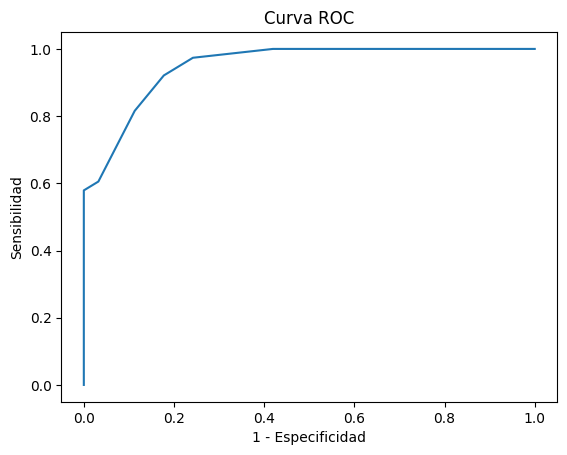

In [28]:
plt.plot(fpr, tpr)
plt.title('Curva ROC')
plt.xlabel('1 - Especificidad')
plt.ylabel('Sensibilidad')

### AUCROC
Ahora calculemos el área bajo la curva ROC, o AUC (o AUCROC), para ello, usaremos otra función de `scikit-learn`

In [29]:
auc_roc = auc(fpr, tpr)
print(auc_roc)

0.9492784380305602


Con esto podemos ver el rendimiento predictivo de la prueba a lo largo de los diferentes puntos de corte, parece ser bastante apropiada, claro que esto es por diseño en estos datos simulados, puedes jugar con la función de generar datos para obtener un dataset diferente.

### Índice de Youden
Ahora veamos cómo calcular el índice de Youden.
Lo que necesitamos hacer es encontrar el punto en la curva donde se se tenga en balance, la máxima sensibilidad con la menor tasa de falsos positivos.

In [30]:
j = np.argmax(tpr-fpr)
print(j)

9


El índice `j` lo obtenemos al encontrar el índice máximo de los elementos resultantes de restar `tpr` y `fpr`, observa qué pasa con esta operación:

In [31]:
tpr-fpr

array([0.        , 0.02631579, 0.18421053, 0.21052632, 0.28947368,
       0.47368421, 0.57894737, 0.57300509, 0.70288625, 0.74363328,
       0.73174873, 0.58064516, 0.41935484, 0.32258065, 0.27419355,
       0.19354839, 0.16129032, 0.09677419, 0.06451613, 0.01612903,
       0.        ])

Si lo cuentas desde el cero, verás que el elemento 9 es el máximo en esta serie de datos. Con el índice `j` ahora podemos obtener el mejor punto de corte (cutoff en inglés) en la curva ROC.

In [32]:
cutoff = th[j]
cutoff

np.float64(20.0)

Según esta simulación, el punto de corte `20` es el que resulta en la mayor sensibilidad y especificidad, veamos cuáles son estos parámetros.
Primero generemos una nueva serie dentro de nuestro arreglo de datos con aquellos puntajes del `Test` que resulten mayores o igual que 20.

In [34]:
df['Predicho'] = df['Test'].ge(cutoff).astype(int)
df.head()

,Estándar,Test,pred,Predicho
0,0,22,1,1
1,0,19,0,0
2,1,23,1,1
3,1,27,1,1
4,0,18,0,0


El método `ge` quiere decir *Grater or Equal* y con este, podemos generar una columna de valores predichos para la enfermedad.
Ahora calculemos tabla cruzada y la sensibilidad y especificidad.

In [35]:
tab = pd.crosstab(df['Predicho'], df['Estándar'])
tab

Estándar,0,1
Predicho,,
0,51,3
1,11,35


### Sensibilidad y Especificidad
Finalmente utilicemos las funciones de sensibilidad y especificidad.

In [36]:
sens = sensibilidad(tab)
esp = especificidad(tab)
sens, esp

(np.float64(0.9210526315789473), np.float64(0.8225806451612904))

### Reporte final
Y reportemos nuestros resultados en forma limpia

In [37]:
print(f"AUCROC: {auc_roc:.3f}, Índice de Youden: {cutoff}, Sensibilidad: {sens:.1%}, Especificidad: {esp:.1%}")

AUCROC: 0.949, Índice de Youden: 20.0, Sensibilidad: 92.1%, Especificidad: 82.3%


## Función completa
Ahora veamos cómo podemos compactar toda esta lógica en una sola función reutilizable.

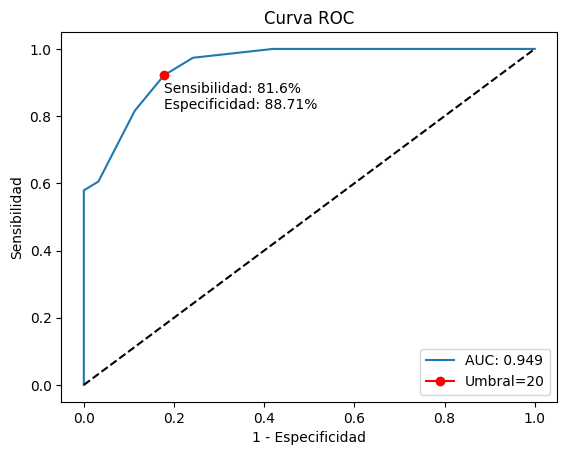

In [81]:
def plot_roc(data, true_col='Estándar', pred_col='Test'):
    """
    La función grafica la curva roc, con su área bajo la curva e índice de Youden y lo retorna.

    Parámetros:
        data: pd.DataFrame
            Arreglo de datos con las columnas que tienen el estado real y el resultado del test
        true_col: str
            Nombre de la columna donde están los valores verdaderos
        pred_col: str
            Nombre de la columna donde están los valores del test que predicen a `true_col`

    """
    fpr, tpr, th = roc_curve(
        data[true_col], data[pred_col],
        drop_intermediate=False
    )
    
    auc_roc = auc(fpr, tpr)
    plt.plot(fpr, tpr, '-', label=f'AUC: {auc_roc:.3f}')
    
    j = np.argmax(tpr-fpr)
    cutoff = th[j].astype(int)
    plt.plot(fpr[j], tpr[j], 'o-r', label=f'Umbral={cutoff}')

    tab = pd.crosstab(df['pred'], df['Estándar'])
    sens = sensibilidad(tab)
    esp = especificidad(tab)
    txt = f'Sensibilidad: {sens:.1%}\nEspecificidad: {esp:.2%}'
    plt.text(fpr[j], tpr[j]-0.1, txt, ha='left')
    
    
    plt.legend()
    plt.plot([0, 1], [0, 1], '--k')
    
    plt.title('Curva ROC')
    plt.ylabel('Sensibilidad')
    plt.xlabel('1 - Especificidad')
    plt.show()
    

plot_roc(df)

## Ejercicios
1. Intenta ejecutar lo aprendido con tus propios datos.
2. Juega con las funciones de simulación para obtener otros datos
3. Intenta utilizar la función de simulación y gráfico en forma repetida
   para conocer los diferentes resultados que pueden generarse.
